# Objectives {.unnumbered}

By the end of this lab, you will:
1. Load and analyze the **Lightcast dataset** in **Spark DataFrame**.
2. Create **five easy and three medium-complexity visualizations** using **Plotly**.
3. Explore **salary distributions, employment trends, and job postings**.
4. Analyze **skills in relation to NAICS/SOC/ONET codes and salaries**.
5. Customize **colors, fonts, and styles** in all visualizations (**default themes result in a 2.5-point deduction**).
6. Follow **best practices for reporting on data communication**.

# Step 1: Load the Dataset {.unnumbered}


In [1]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "vscode"
from pyspark.sql import SparkSession
from pyspark.sql.functions import col


# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("./lightcast_job_postings.csv")

# Show Schema and Sample Data
df.printSchema()
df.show(5)


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/27 03:55:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- ID: string (nullable = true)
 |-- LAST_UPDATED_DATE: string (nullable = true)
 |-- LAST_UPDATED_TIMESTAMP: timestamp (nullable = true)
 |-- DUPLICATES: integer (nullable = true)
 |-- POSTED: string (nullable = true)
 |-- EXPIRED: string (nullable = true)
 |-- DURATION: integer (nullable = true)
 |-- SOURCE_TYPES: string (nullable = true)
 |-- SOURCES: string (nullable = true)
 |-- URL: string (nullable = true)
 |-- ACTIVE_URLS: string (nullable = true)
 |-- ACTIVE_SOURCES_INFO: string (nullable = true)
 |-- TITLE_RAW: string (nullable = true)
 |-- BODY: string (nullable = true)
 |-- MODELED_EXPIRED: string (nullable = true)
 |-- MODELED_DURATION: integer (nullable = true)
 |-- COMPANY: integer (nullable = true)
 |-- COMPANY_NAME: string (nullable = true)
 |-- COMPANY_RAW: string (nullable = true)
 |-- COMPANY_IS_STAFFING: boolean (nullable = true)
 |-- EDUCATION_LEVELS: string (nullable = true)
 |-- EDUCATION_LEVELS_NAME: string (nullable = true)
 |-- MIN_EDULEVELS: integer (

25/03/27 03:56:00 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+-----------------+----------------------+----------+--------+---------+--------+--------------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+---------------+----------------+--------+--------------------+-----------+-------------------+----------------+---------------------+-------------+-------------------+-------------+------------------+---------------+--------------------+--------------------+--------------------+-------------+------+-----------+----------------+-------------------+---------+-----------+--------------------+--------------------+-------------+------+--------------+-----+--------------------+-----+----------+---------------+--------------------+---------------+--------------------+------------+--------------------+------------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+------

# Salary Distribution by Employment Type
- Identify salary trends across different employment types.
- **Filter the dataset**
  - Remove records where **salary is missing or zero**.
- **Aggregate Data**
  - Group by **employment type** and compute salary distribution.
- **Visualize results**
  - Create a **box plot** where:
    - **X-axis** = `EMPLOYMENT_TYPE_NAME`
    - **Y-axis** = `SALARY_FROM`
  - Customize **colors, fonts, and styles** to avoid a **2.5-point deduction**.
- **Explanation:** Write two sentences about what the graph reveals.



/tmp/ipykernel_2588/2113049448.py:18: FutureWarning:                            



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




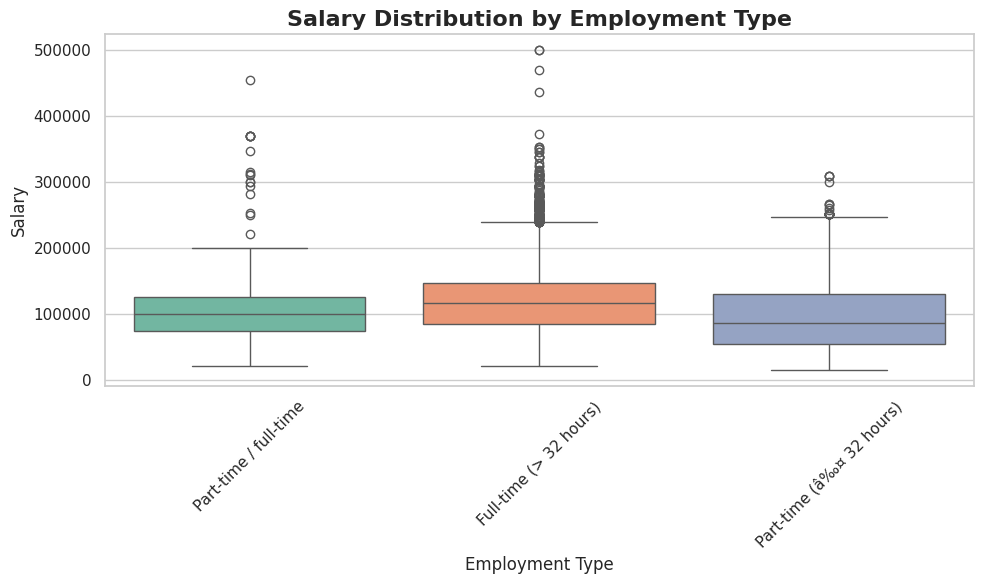

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter out rows with null or zero salary
filtered_df = df.filter((df["SALARY"].isNotNull()) & (df["SALARY"] > 0))

# Convert to Pandas DataFrame
pdf = pd.DataFrame(
    filtered_df.select("EMPLOYMENT_TYPE_NAME", "SALARY").collect(),
    columns=["EMPLOYMENT_TYPE_NAME", "SALARY"]
)

# Create static box plot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

sns.boxplot(
    data=pdf,
    x="EMPLOYMENT_TYPE_NAME",
    y="SALARY",
    palette="Set2"
)

# Enhance chart styling
plt.title("Salary Distribution by Employment Type", fontsize=16, fontweight='bold')
plt.xlabel("Employment Type")
plt.ylabel("Salary")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


The box plot clearly illustrates that full-time positions (>32 hours) generally offer higher median salaries compared to part-time positions. Additionally, part-time/full-time roles exhibit greater salary variability and have more extreme high-value outliers compared to purely part-time roles.

# Salary Distribution by Industry
- Compare salary variations across industries.
- **Filter the dataset**
  - Keep records where **salary is greater than zero**.
- **Aggregate Data**
  - Group by **NAICS industry codes**.
- **Visualize results**
  - Create a **box plot** where:
    - **X-axis** = `NAICS2_NAME`
    - **Y-axis** = `SALARY_FROM`
  - Customize colors, fonts, and styles.
- **Explanation:** Write two sentences about what the graph reveals.

/tmp/ipykernel_2588/3874091909.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


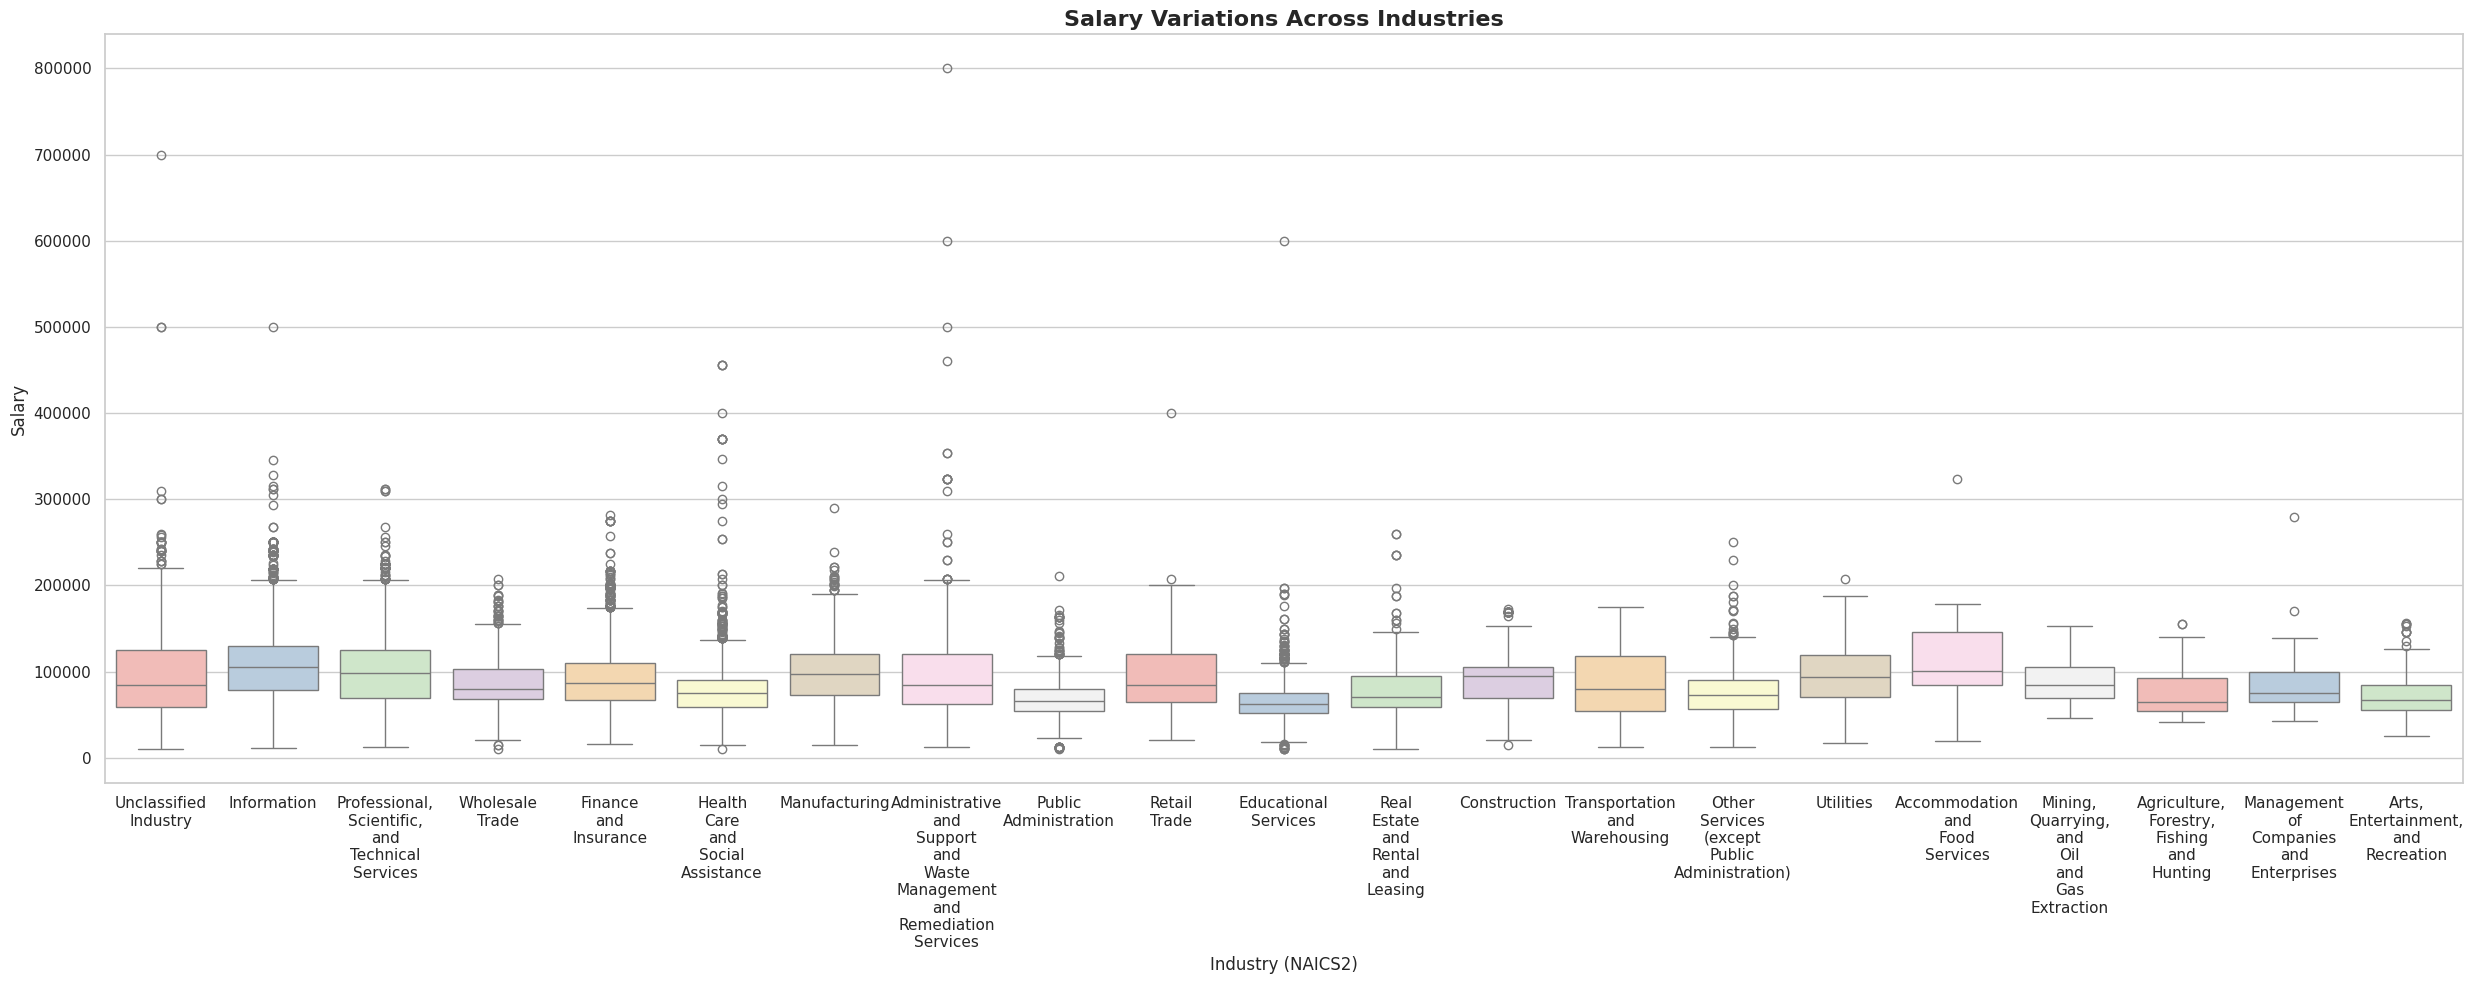

In [6]:
# Optional: wrap long names for readability
pdf["NAICS2_NAME"] = pdf["NAICS2_NAME"].apply(lambda x: '\n'.join(x.split()))

plt.figure(figsize=(25, 10))
sns.set(style="whitegrid")

sns.boxplot(
    data=pdf,
    x="NAICS2_NAME",
    y="SALARY_FROM",
    palette="Pastel1"
)

plt.title("Salary Variations Across Industries", fontsize=16, fontweight='bold', family="Arial")
plt.xlabel("Industry (NAICS2)")
plt.ylabel("Salary")
plt.tight_layout()
plt.show()


The box plot shows that salary distributions vary significantly across industries, with sectors like Unclassified Industry, Information, and Waste Management and Remediation Services offering higher and more dispersed salaries. In contrast, industries like Art, Entertatainment or Agriculture generally show lower and more compact salary ranges.

# Job Posting Trends Over Time
- Analyze how job postings fluctuate over time.
- **Aggregate Data**
  - Count job postings per **posted date (`POSTED`)**.
- **Visualize results**
  - Create a **line chart** where:
    - **X-axis** = `POSTED`
    - **Y-axis** = `Number of Job Postings`
  - Apply custom colors and font styles.
- **Explanation:** Write two sentences about what the graph reveals.

findfont: Font family 'Arial' not found.                                        
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


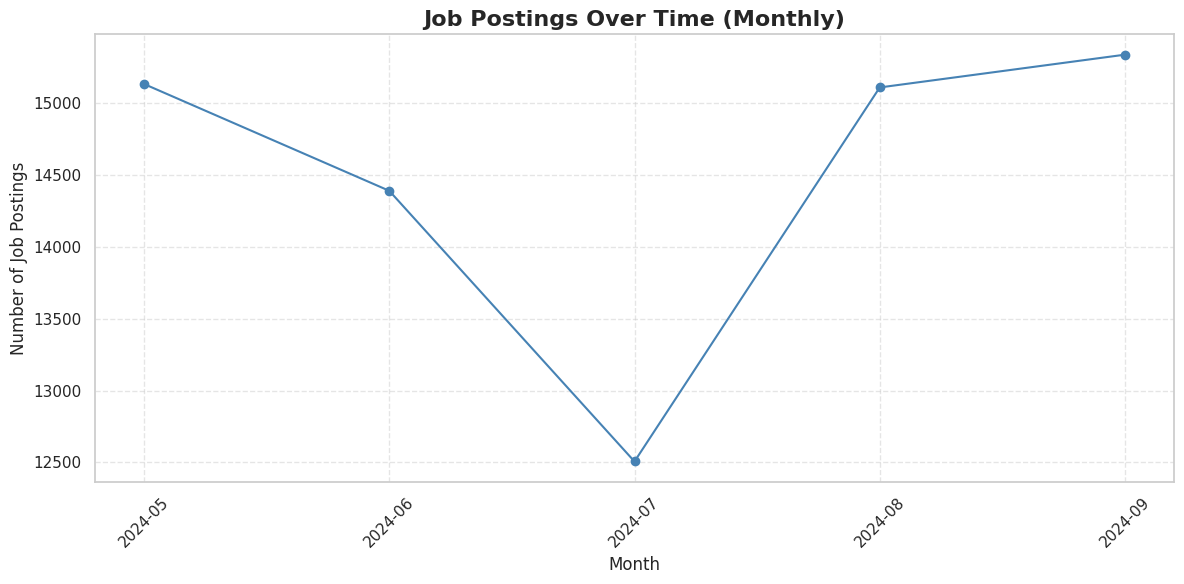

In [ ]:
from pyspark.sql.functions import to_date, col, count, date_format

# Convert string to date format
df_with_date = df.withColumn("POSTED_DATE", to_date(col("POSTED"), "M/d/yyyy"))


# Extract monthly date and count job postings
df_grouped = df_with_date.withColumn("POSTED_MONTH", date_format("POSTED_DATE", "yyyy-MM")) \
                         .groupBy("POSTED_MONTH") \
                         .agg(count("*").alias("NUM_POSTINGS"))

# Convert to Pandas
pdf = pd.DataFrame(
    df_grouped.sort("POSTED_MONTH").collect(),
    columns=["POSTED_MONTH", "NUM_POSTINGS"]
)

# Clean data
pdf = pdf[pdf["POSTED_MONTH"].notnull()]
pdf["POSTED_MONTH"] = pdf["POSTED_MONTH"].astype(str)

# Plot using Matplotlib
plt.figure(figsize=(12, 6))
plt.plot(
    pdf["POSTED_MONTH"],
    pdf["NUM_POSTINGS"],
    marker='o',
    linestyle='-',
    color='steelblue'
)

# Style the chart
plt.title("Job Postings Over Time (Monthly)", fontsize=16, fontweight='bold', family='Arial')
plt.xlabel("Month")
plt.ylabel("Number of Job Postings")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()



The chart shows that the number of job postings decreased during the summer, while postings remained consistent at the beginning and end of the year. With more than 11,000 job postings each month, it reflects a high and steady demand for workers in the U.S.

# Top 10 Job Titles by Count
- Identify the most frequently posted job titles.
- **Aggregate Data**
  - Count the occurrences of each **job title (`TITLE_NAME`)**.
  - Select the **top 10 most frequent titles**.
- **Visualize results**
  - Create a **bar chart** where:
    - **X-axis** = `TITLE_NAME`
    - **Y-axis** = `Job Count`
  - Apply custom colors and font styles.
- **Explanation:** Write two sentences about what the graph reveals.

findfont: Font family 'Arial' not found.                                        
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


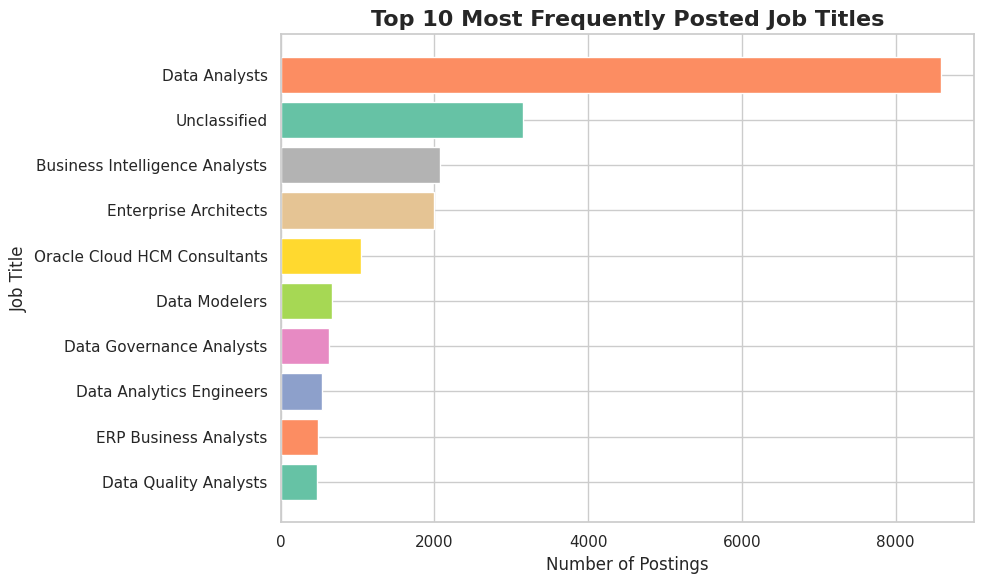

In [ ]:
from pyspark.sql.functions import col, count

# Group and get top 10 jobs
job_counts = df.groupBy("TITLE_NAME").agg(count("*").alias("JOB_COUNT"))
top_10_jobs = job_counts.orderBy(col("JOB_COUNT").desc()).limit(10)

# Convert to Pandas
pdf = pd.DataFrame(top_10_jobs.collect(), columns=["TITLE_NAME", "JOB_COUNT"])

# sort again in pandas for nicer order in bar chart
pdf = pdf.sort_values("JOB_COUNT", ascending=True)

# Bar chart
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

plt.barh(pdf["TITLE_NAME"], pdf["JOB_COUNT"], color=sns.color_palette("Set2", len(pdf)))

# Step 4: Style
plt.title("Top 10 Most Frequently Posted Job Titles", fontsize=16, fontweight='bold', family='Arial')
plt.xlabel("Number of Postings")
plt.ylabel("Job Title")
plt.tight_layout()
plt.show()

The chart shows that Data Analyst is the most frequently posted job title, with more than double the postings compared to other roles—highlighting the strong demand for data professionals. In contrast, Data Quality Analyst appears the least among the top 10, suggesting it is a more specialized or less commonly advertised role.

# Remote vs On-Site Job Postings
- Compare the proportion of remote and on-site job postings.
- **Aggregate Data**
  - Count job postings by **remote type (`REMOTE_TYPE_NAME`)**.
- **Visualize results**
  - Create a **pie chart** where:
    - **Labels** = `REMOTE_TYPE_NAME`
    - **Values** = `Job Count`
  - Apply custom colors and font styles.
- **Explanation:** Write two sentences about what the graph reveals.

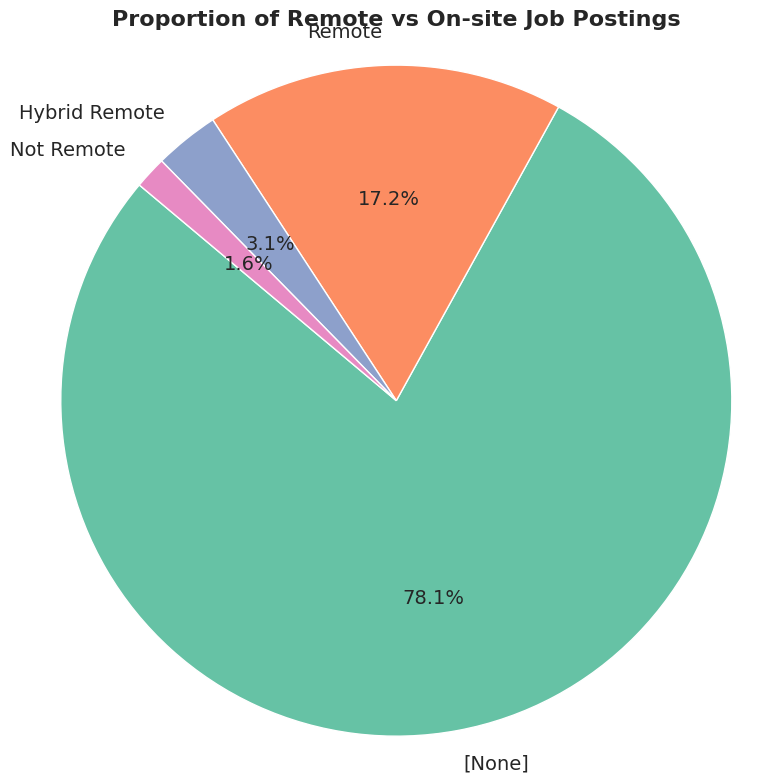

In [13]:
from pyspark.sql.functions import count

# Group and convert
remote_counts = df.groupBy("REMOTE_TYPE_NAME").agg(count("*").alias("JOB_COUNT"))
pdf = pd.DataFrame(remote_counts.collect(), columns=["REMOTE_TYPE_NAME", "JOB_COUNT"])

# Drop rows with missing REMOTE_TYPE_NAME
pdf = pdf[pdf["REMOTE_TYPE_NAME"].notnull()]

# Sort by size
pdf = pdf.sort_values("JOB_COUNT", ascending=False)

# Define custom colors (lighter + distinct)
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']  # pastel tones

# Create pie chart
plt.figure(figsize=(8, 8))
plt.pie(
    pdf["JOB_COUNT"],
    labels=pdf["REMOTE_TYPE_NAME"],
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    textprops={'fontsize': 14}
)

plt.title("Proportion of Remote vs On-site Job Postings", fontsize=16, fontweight='bold')
plt.axis('equal')
plt.tight_layout()
plt.show()




The pie chart reveals that a majority of job postings (78%) are for on-site positions, while remote roles make up 17.2%, and hybrid opportunities account for only 1.55%. This suggests that despite the growth of remote work trends, many employers still prioritize in-person collaboration—possibly due to the nature of the industry, security requirements, or company culture.

# Skill Demand Analysis by Industry (Stacked Bar Chart)
- Identify which skills are most in demand in various industries.
- **Aggregate Data**
  - Extract **skills** from job postings.
  - Count occurrences of skills grouped by **NAICS industry codes**.
- **Visualize results**
  - Create a **stacked bar chart** where:
    - **X-axis** = `Industry`
    - **Y-axis** = `Skill Count`
    - **Color** = `Skill`
  - Apply custom colors and font styles.
- **Explanation:** Write two sentences about what the graph reveals.

findfont: Font family 'Arial' not found.                                        
findfont: Font family 'Arial' not found.


<Figure size 1400x700 with 0 Axes>

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


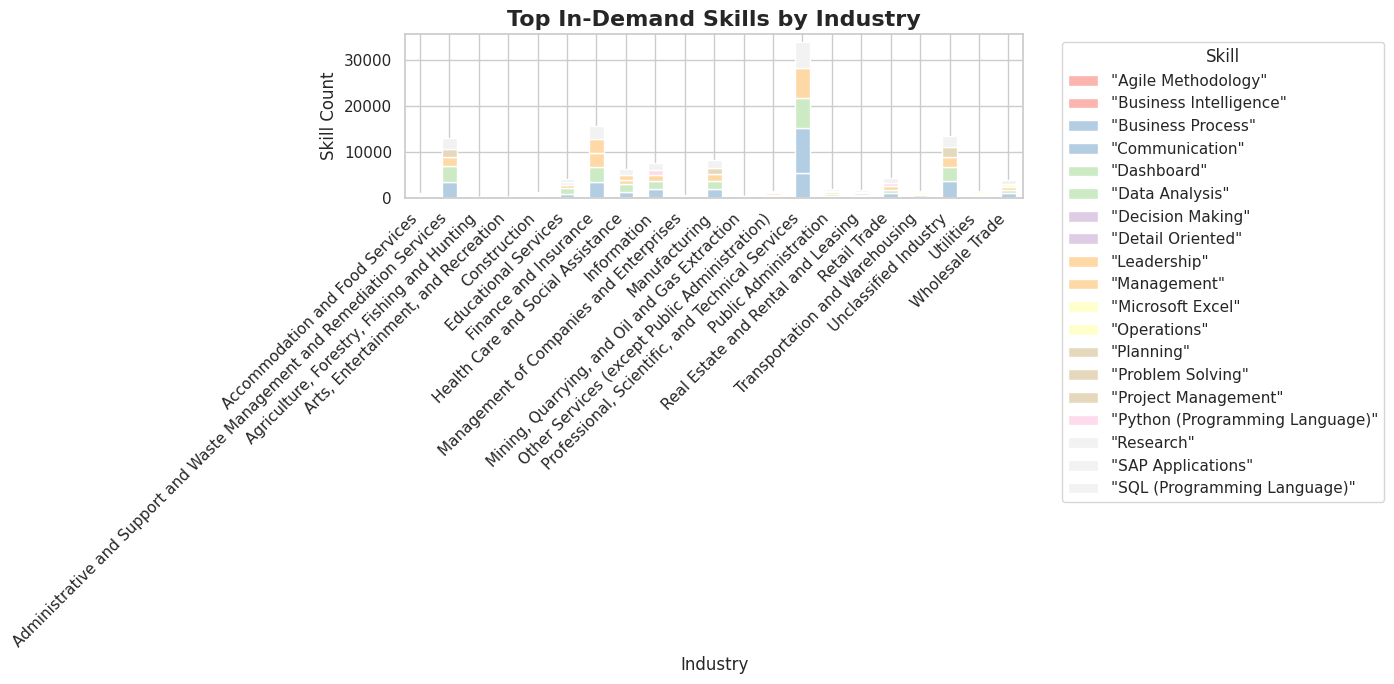

In [ ]:
from pyspark.sql.functions import split, explode, col, count, row_number
from pyspark.sql.window import Window

# Extract and explode skills
skills_df = df.withColumn("SKILLS_NAME", explode(split(col("SKILLS_NAME"), ",\\s*")))

# Group and count skill occurrences by industry
industry_skills = skills_df.groupBy("NAICS2_NAME", "SKILLS_NAME") \
                           .agg(count("*").alias("SKILL_COUNT"))

# Limit to top 5 skills per industry using window function
windowSpec = Window.partitionBy("NAICS2_NAME").orderBy(col("SKILL_COUNT").desc())
top_skills_per_industry = industry_skills.withColumn("rank", row_number().over(windowSpec)) \
                                         .filter(col("rank") <= 5)

# Convert to Pandas
pdf = pd.DataFrame(
    top_skills_per_industry.select("NAICS2_NAME", "SKILLS_NAME", "SKILL_COUNT").collect(),
    columns=["NAICS2_NAME", "SKILLS_NAME", "SKILL_COUNT"]
)

# Plot as stacked bar chart using seaborn
plt.figure(figsize=(14, 7))
sns.set(style="whitegrid")

# Create pivot table for stacked bar format
pivot_df = pdf.pivot(index="NAICS2_NAME", columns="SKILLS_NAME", values="SKILL_COUNT").fillna(0)

# Plot stacked bars
pivot_df.plot(kind="bar", stacked=True, colormap="Pastel1", figsize=(14, 7))

# Style it
plt.title("Top In-Demand Skills by Industry", fontsize=16, fontweight="bold", family="Arial")
plt.xlabel("Industry")
plt.ylabel("Skill Count")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Skill", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



Across most industries, the most in-demand skills include data analysis, communication, problem-solving, and management. These skills are highly valued because they are essential for making data-driven decisions, collaborating effectively in teams, and navigating complex business challenges—regardless of industry.


# Salary Analysis by ONET Occupation Type (Bubble Chart)
- Analyze how salaries differ across ONET occupation types.
- **Aggregate Data**
  - Compute **median salary** for each occupation in the **ONET taxonomy**.
- **Visualize results**
  - Create a **bubble chart** where:
    - **X-axis** = `ONET_NAME`
    - **Y-axis** = `Median Salary`
    - **Size** = Number of job postings
  - Apply custom colors and font styles.
- **Explanation:** Write two sentences about what the graph reveals.

findfont: Font family 'Arial' not found.                                        
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.


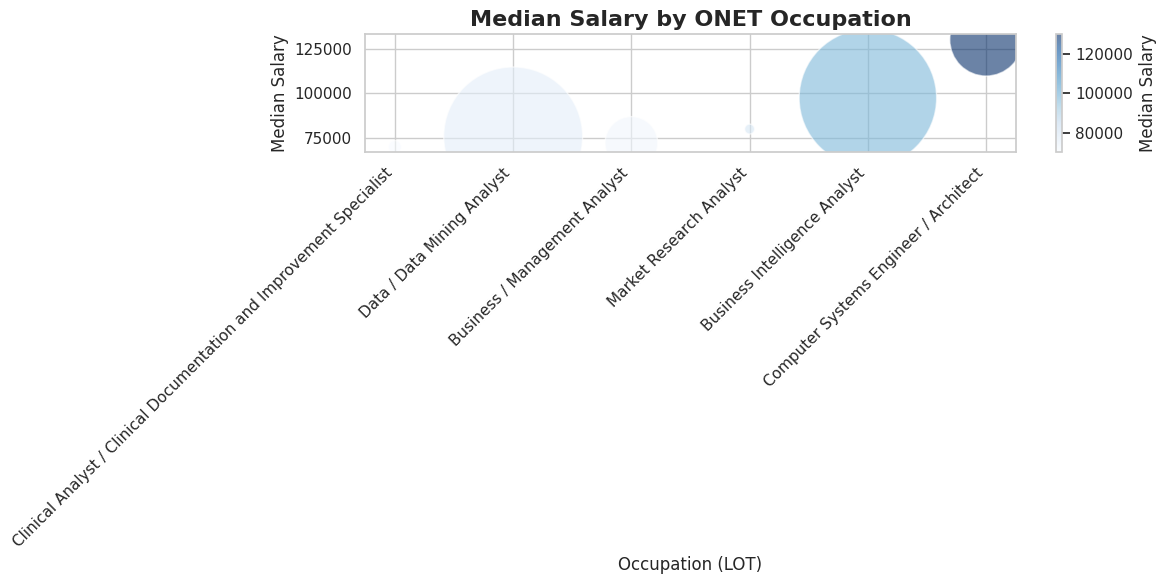

In [ ]:
from pyspark.sql.functions import count, percentile_approx

# Group by ONET and LOT occupation
onet_summary = df.groupBy("ONET_NAME", "LOT_OCCUPATION_NAME") \
    .agg(
        count("*").alias("JOB_COUNT"),
        percentile_approx("SALARY_FROM", 0.5).alias("MEDIAN_SALARY")
    )

# Convert to Pandas
pdf = pd.DataFrame(
    onet_summary.collect(),
    columns=["ONET_NAME", "LOT_OCCUPATION_NAME", "JOB_COUNT", "MEDIAN_SALARY"]
)

pdf = pdf[pdf["LOT_OCCUPATION_NAME"].notnull() & pdf["MEDIAN_SALARY"].notnull()]

# Plot using Matplotlib (bubble = size of JOB_COUNT)
plt.figure(figsize=(12, 6))

# Normalize sizes for better visuals
size_scale = 100  # Adjust this to control bubble size
plt.scatter(
    pdf["LOT_OCCUPATION_NAME"],
    pdf["MEDIAN_SALARY"],
    s=pdf["JOB_COUNT"] / pdf["JOB_COUNT"].max() * size_scale**2,
    c=pdf["MEDIAN_SALARY"],
    cmap="Blues",
    alpha=0.6,
    edgecolors="w"
)

# Styling
plt.title("Median Salary by ONET Occupation", fontsize=16, fontweight='bold', family="Arial")
plt.xlabel("Occupation (LOT)")
plt.ylabel("Median Salary")
plt.xticks(rotation=45, ha="right")
plt.colorbar(label="Median Salary")
plt.tight_layout()
plt.show()




In the chart, Computer Systems Engineers have a higher median salary compared to Business Intelligence Analysts, reflecting stronger compensation in technical engineering roles. Meanwhile, Data Mining Specialists show the lowest median salary among the ONET occupations, suggesting either lower demand or entry-level positioning in the market.

# Career Pathway Trends (Sankey Diagram)
- Visualize job transitions between different occupation levels.
- **Aggregate Data**
  - Identify career transitions between **SOC job classifications**.
- **Visualize results**
  - Create a **Sankey diagram** where:
    - **Source** = `SOC_2021_2_NAME`
    - **Target** = `SOC_2021_3_NAME`
    - **Value** = Number of transitions
  - Apply custom colors and font styles.
- **Explanation:** Write two sentences about what the graph reveals.

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


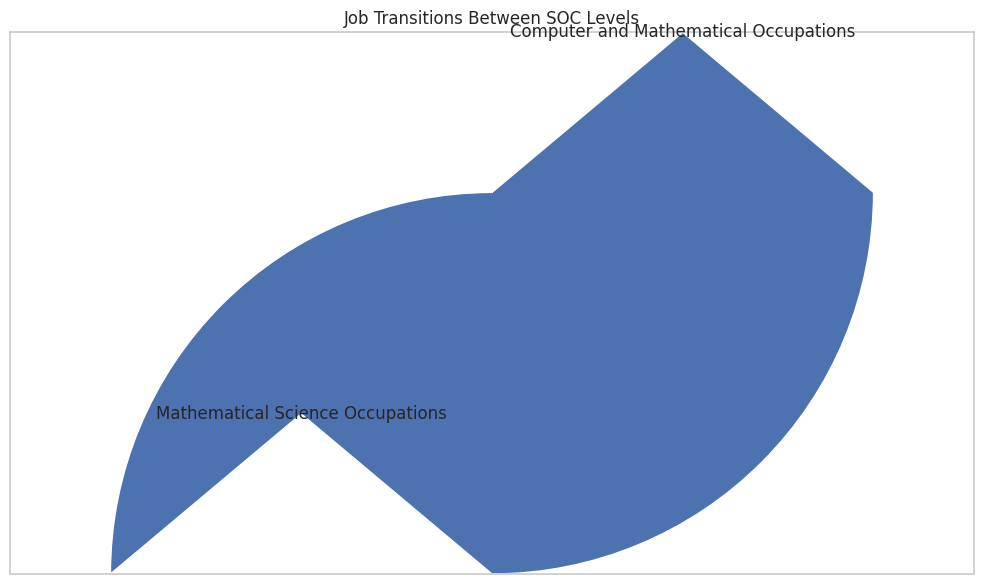

In [20]:
from matplotlib.sankey import Sankey
from pyspark.sql.functions import count

# Step 1: Aggregate transitions
transitions_df = df.groupBy("SOC_2021_2_NAME", "SOC_2021_3_NAME") \
                   .agg(count("*").alias("TRANSITIONS"))

# Step 2: Convert to Pandas
pdf = pd.DataFrame(
    transitions_df.collect(),
    columns=["SOC_2021_2_NAME", "SOC_2021_3_NAME", "TRANSITIONS"]
)

# Step 3: Drop None values for cleaner rendering
pdf = pdf.dropna(subset=["SOC_2021_2_NAME", "SOC_2021_3_NAME"])

# Step 4: Select top N transitions for clarity
pdf = pdf.sort_values("TRANSITIONS", ascending=False).head(5)

# Step 5: Prepare labels and flows
source_labels = pdf["SOC_2021_2_NAME"].tolist()
target_labels = pdf["SOC_2021_3_NAME"].tolist()
values = pdf["TRANSITIONS"].tolist()

# Merge labels for Sankey index
labels = list(set(source_labels + target_labels))
label_to_index = {label: i for i, label in enumerate(labels)}

# Map indices
sources = [label_to_index[s] for s in source_labels]
targets = [label_to_index[t] for t in target_labels]

# Step 6: Basic Sankey Diagram (one-to-many)
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[], title="Job Transitions Between SOC Levels")

sankey = Sankey(ax=ax, unit=None)
for i in range(len(pdf)):
    sankey.add(flows=[-values[i], values[i]],
               labels=[source_labels[i], target_labels[i]],
               orientations=[1, -1])
sankey.finish()
plt.tight_layout()
plt.show()




The Sankey diagram shows a single transition from Computer and Mathematical Occupations to Mathematical Science Occupations, indicating that this is the only job flow captured in the current dataset. This may suggest that the data is focused on a specific occupational pathway—such as transitions within data or analytics-related roles—or that other occupation transitions were not recorded or available.